# Facial Recognition

### Changes:
- Make use of triplet mining which is a technique for selecting training samples called triplets to improve the performance of models that use triplet loss.
- Custom learning rate scheduler which should allow the model to make finer changes as LR slowly decreases and escape local minima via warm restarts.

## 1. Dependencies and Imports

In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torch import nn
from torch.nn import functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, LRScheduler
from pytorch_metric_learning import miners, losses, samplers, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from torchsummary import summary

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import join 
from tqdm import tqdm
import pandas as pd
import numpy as np
import math

In [3]:
# Set device to GPU if it exists for faster training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 2. Load and preprocess data

In [4]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    torchvision.transforms.
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [5]:
root = 'dataset_lb'
train_ds = ImageFolder(join(root, 'train'), transform=train_transform)
val_ds = ImageFolder(join(root, 'val'), transform=val_transform)

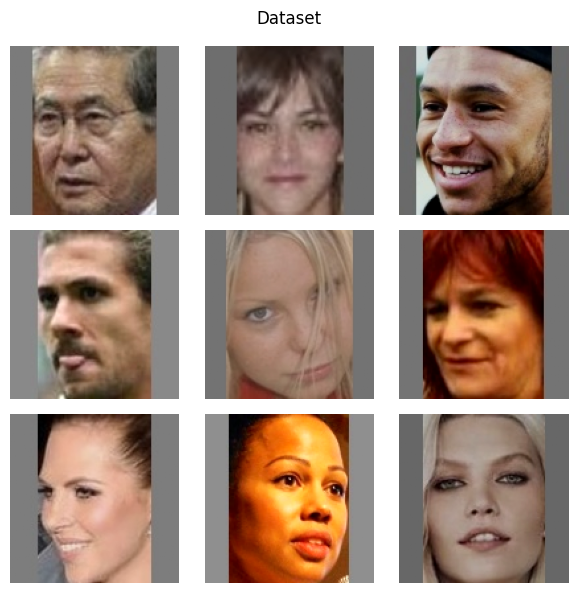

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i in range(9):
    axes[i // 3][i % 3].imshow(train_ds[np.random.randint(0, len(train_ds)-1)][0].permute(1, 2, 0) / 2 + .5)
    axes[i // 3][i % 3].axis(False)
    
plt.suptitle('Dataset')
plt.tight_layout()
plt.show()

In [7]:
# Choose 8 images per class for a total of 16 classes
batch_size = 128
train_sampler = samplers.MPerClassSampler(train_ds.targets, m=8, batch_size=batch_size)

train_dataloader = DataLoader(train_ds, batch_size, sampler=train_sampler)
val_dataloader = DataLoader(val_ds, batch_size)

## Model network

<center><img src="image.png" style="background-color: white;" width=40%></center>

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, *, activation=True, use_batchnorm=True, dropout_p=0.1):
        super().__init__()
        padding = self.same_padding(kernel_size)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=not use_batchnorm)
        self.bn1 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()
        self.activation = activation if isinstance(activation, nn.Module) else nn.SiLU() if activation else nn.Identity()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()

        if (in_channels != out_channels) or (stride != 1):
            self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.residual = nn.Identity()
        self.dropout = nn.Dropout(dropout_p) if dropout_p > 0 else nn.Identity()
    
    def same_padding(self, kernel_size):
        return (kernel_size - 1) // 2
    
    def forward(self, x):
        residual = self.residual(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.dropout(x)
        x = x + residual
        x = self.activation(x)
        return x

In [9]:
class Model(nn.Module):
    def __init__(self, in_channels, embedding_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=5, padding=2),
            ResidualBlock(16, 32, kernel_size=3, stride=2),
            ResidualBlock(32, 64, kernel_size=3, stride=2),
            ResidualBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128, 256, kernel_size=3, stride=2),
            ResidualBlock(256, 384, kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(384, embedding_dim)
        )
    
    def forward(self, x):
        return F.normalize(self.encoder(x))  # Normalizes vector to unit length 1

In [10]:
model = Model(3, 128)
summary(model, input_size=(3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]           1,216
            Conv2d-2           [-1, 32, 64, 64]             544
            Conv2d-3           [-1, 32, 64, 64]           4,608
       BatchNorm2d-4           [-1, 32, 64, 64]              64
              SiLU-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           9,248
       BatchNorm2d-7           [-1, 32, 64, 64]              64
           Dropout-8           [-1, 32, 64, 64]               0
              SiLU-9           [-1, 32, 64, 64]               0
    ResidualBlock-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 64, 32, 32]           2,112
           Conv2d-12           [-1, 64, 32, 32]          18,432
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             SiLU-14           [-1, 64,

## 3. Model Training

In [11]:
# Similar to Cosine Annealing with Warm Restarts but each restart lowers the initial learning rate by some factor.
# Also makes the frequency of restarts lower. 
class CosineAnnealingWarmRestartsWeightDecay(LRScheduler):
    def __init__(self, optimizer, T_0, lr_decay=0.5, T_mult=2, eta_min=0, last_epoch=-1):
        """
        Args:
            optimizer: Optimizer to apply the schedule to.
            T_0 (int): Number of iterations for the first restart cycle.
            lr_decay (float): Multiplicative factor for max_lr after each restart.
            T_mult (int): Cycle length multiplier.
            eta_min (float): Minimum learning rate.
            last_epoch (int): Start at last_epoch.
        """
        self.T_0 = T_0
        self.T_i = T_0
        self.lr_decay = lr_decay
        self.T_mult = T_mult
        self.eta_min = eta_min

        self.cycle = 0
        self.T_cur = last_epoch

        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs

        cosine_term = [
            self.eta_min + (base_lr * (self.lr_decay ** self.cycle) - self.eta_min) *
            (1 + math.cos(math.pi * self.T_cur / self.T_i)) / 2
            for base_lr in self.base_lrs
        ]
        return cosine_term

    def step(self, epoch=None):
        if epoch is None:
            self.T_cur += 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = 0
                self.T_i *= self.T_mult
        else:
            if self.T_mult == 1:
                self.T_i = self.T_0
                self.T_cur = epoch % self.T_0
                self.cycle = epoch // self.T_0
            else:
                n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                self.cycle = n
                self.T_i = self.T_0 * self.T_mult ** n
                self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) // (self.T_mult - 1)

        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [12]:
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

In [13]:
def train_step(model, dataloader, optimizer, scheduler, loss_fn, mine_fn, device, epoch=0):
    model.train()

    iters = len(dataloader)  # Count number of iterations for our scheduler
    total_loss, total_samples = 0, 0
    progress_bar = tqdm(dataloader, desc='Train')
    for i, (img, labels) in enumerate(progress_bar):
        img, labels = img.to(device), labels.to(device)
        B = img.size(0)
        optimizer.zero_grad()

        embeddings = model(img)

        indices = mine_fn(embeddings, labels)

        loss = loss_fn(embeddings, labels, indices)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B
        total_samples += B

        avg_loss = total_loss / total_samples

        lr = optimizer.param_groups[0]['lr']
        progress_bar.set_postfix({'loss': avg_loss, 'lr': lr})
        scheduler.step(epoch + i / iters)
    return avg_loss

In [14]:
@torch.no_grad()
def val_step(model, ds, device):
    model.eval()

    val_embeddings, val_labels = get_all_embeddings(ds, model)
    val_labels = val_labels.squeeze()

    acc_calc = AccuracyCalculator(avg_of_avgs=True, k='max_bin_count', device=device)
    res = acc_calc.get_accuracy(
        val_embeddings, val_labels,
        val_embeddings, val_labels,
        ref_includes_query=True
    )
    
    return res

In [15]:
# Each epoch takes around ~4 mins
STARTING_EPOCH = 0  # To be loaded from checkpoint if it exists
NUM_EPOCHES = 200

distance = distances.CosineSimilarity()
loss_fn = losses.TripletMarginLoss(margin=0.3, distance=distance)
mine_fn = miners.BatchEasyHardMiner(
    pos_strategy='easy',
    neg_strategy='semihard'
)

In [16]:
model = Model(3, 128).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingWarmRestartsWeightDecay(optimizer, T_0=10, lr_decay=0.8, T_mult=1.2, eta_min=1e-6)

history = {}

In [ ]:
# # Optionally load the model from a checkpoint
# checkpoint = torch.load('model_checkpoints/model_005.pt', weights_only=False)
# checkpoint = torch.load('model_checkpoints/best_model.pt', weights_only=False)

# STARTING_EPOCH = checkpoint['epoch']
# history = checkpoint['history']
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [18]:
# Keep track of precision_at_1 (P@1): Fraction of queries where the top-1 result is correct.
# How often is the first item correct? (Relevant for our facial recognition as we only obtain the first item)

# Initial validation to check base stats on untrained model
history[STARTING_EPOCH] = {}
history[STARTING_EPOCH]['val_metrics'] = val_step(model, val_ds, device)
history[STARTING_EPOCH]['val_metrics']

100%|██████████| 661/661 [00:09<00:00, 68.19it/s] 


{'AMI': np.float64(0.0624390328247148),
 'NMI': np.float64(0.08281132658447127),
 'mean_average_precision': 0.005849436970151017,
 'mean_average_precision_at_r': 0.004504721409115295,
 'mean_reciprocal_rank': 0.23028400540351868,
 'precision_at_1': 0.131563970636737,
 'r_precision': 0.03699375543638701}

In [19]:
if len(history) == 0:
    best_precision_at_1 = 0
else:
    best_precision_at_1 = max(row['val_metrics']['precision_at_1'] for row in history.values())

# Training loop
for epoch in range(STARTING_EPOCH, NUM_EPOCHES):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHES}:')
    history[epoch + 1] = history.get(epoch + 1, {})  # If no dictionary exists at history[epoch + 1], initialize one. 
    
    train_loss = train_step(model, train_dataloader, optimizer, scheduler, loss_fn, mine_fn, device, epoch)
    val_metrics = val_step(model, val_ds, device)
    
    # Keep a history of train loss and metrics to visualize later
    history[epoch + 1]["train_loss"] = train_loss
    history[epoch + 1]['val_metrics'] = val_metrics
    
    if val_metrics['precision_at_1'] > best_precision_at_1:
        best_precision_at_1 = val_metrics['precision_at_1']
        print(f'New best validation P@1: {best_precision_at_1:.4f}')
    
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'time_saved': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }, f'model_checkpoints/best_model.pt')  # Overwrites the previous best model
    else:
        print(f'Validation P@1: {val_metrics["precision_at_1"]:.4f}. Best: {best_precision_at_1:.4f}')
        

    if (epoch + 1) % 5 == 0 or epoch == NUM_EPOCHES - 1:
        print('Saving checkpoint...')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'time_saved': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }, f'model_checkpoints/model_{epoch + 1:03d}.pt')
    print()

Epoch 1/200:


100%|██████████| 661/661 [00:09<00:00, 67.99it/s] 


New best validation P@1: 0.2499

Epoch 2/200:


100%|██████████| 661/661 [00:09<00:00, 68.89it/s] 


New best validation P@1: 0.4178

Epoch 3/200:


100%|██████████| 661/661 [00:09<00:00, 67.58it/s] 


New best validation P@1: 0.5324

Epoch 4/200:


100%|██████████| 661/661 [00:09<00:00, 67.12it/s] 


New best validation P@1: 0.6060

Epoch 5/200:


100%|██████████| 661/661 [00:09<00:00, 67.66it/s] 


New best validation P@1: 0.6307
Saving checkpoint...

Epoch 6/200:


100%|██████████| 661/661 [00:09<00:00, 68.84it/s] 


New best validation P@1: 0.6576

Epoch 7/200:


100%|██████████| 661/661 [00:09<00:00, 68.16it/s] 


New best validation P@1: 0.6757

Epoch 8/200:


100%|██████████| 661/661 [00:09<00:00, 68.95it/s] 


New best validation P@1: 0.6918

Epoch 9/200:


100%|██████████| 661/661 [00:09<00:00, 67.70it/s] 


New best validation P@1: 0.6956

Epoch 10/200:


100%|██████████| 661/661 [00:09<00:00, 68.63it/s] 


New best validation P@1: 0.6972
Saving checkpoint...

Epoch 11/200:


100%|██████████| 661/661 [00:09<00:00, 68.54it/s] 


Validation P@1: 0.6857. Best: 0.6972

Epoch 12/200:


100%|██████████| 661/661 [00:09<00:00, 68.47it/s] 


Validation P@1: 0.6929. Best: 0.6972

Epoch 13/200:


100%|██████████| 661/661 [00:09<00:00, 68.85it/s] 


New best validation P@1: 0.7084

Epoch 14/200:


100%|██████████| 661/661 [00:09<00:00, 68.52it/s] 


New best validation P@1: 0.7175

Epoch 15/200:


100%|██████████| 661/661 [00:09<00:00, 69.12it/s] 


New best validation P@1: 0.7277
Saving checkpoint...

Epoch 16/200:


100%|██████████| 661/661 [00:09<00:00, 68.44it/s] 


New best validation P@1: 0.7318

Epoch 17/200:


100%|██████████| 661/661 [00:09<00:00, 68.56it/s] 


New best validation P@1: 0.7393

Epoch 18/200:


100%|██████████| 661/661 [00:11<00:00, 55.81it/s] 


New best validation P@1: 0.7433

Epoch 19/200:


100%|██████████| 661/661 [00:09<00:00, 68.80it/s] 


New best validation P@1: 0.7487

Epoch 20/200:


100%|██████████| 661/661 [00:09<00:00, 68.88it/s] 


New best validation P@1: 0.7547
Saving checkpoint...

Epoch 21/200:


100%|██████████| 661/661 [00:09<00:00, 69.15it/s] 


Validation P@1: 0.7541. Best: 0.7547

Epoch 22/200:


100%|██████████| 661/661 [00:09<00:00, 68.33it/s] 


Validation P@1: 0.7545. Best: 0.7547

Epoch 23/200:


100%|██████████| 661/661 [00:09<00:00, 68.80it/s] 


Validation P@1: 0.7348. Best: 0.7547

Epoch 24/200:


100%|██████████| 661/661 [00:09<00:00, 69.50it/s] 


Validation P@1: 0.7381. Best: 0.7547

Epoch 25/200:


100%|██████████| 661/661 [00:09<00:00, 68.39it/s] 


Validation P@1: 0.7494. Best: 0.7547
Saving checkpoint...

Epoch 26/200:


100%|██████████| 661/661 [00:09<00:00, 69.57it/s] 


Validation P@1: 0.7446. Best: 0.7547

Epoch 27/200:


100%|██████████| 661/661 [00:09<00:00, 68.30it/s] 


Validation P@1: 0.7502. Best: 0.7547

Epoch 28/200:


100%|██████████| 661/661 [00:09<00:00, 69.21it/s] 


Validation P@1: 0.7537. Best: 0.7547

Epoch 29/200:


100%|██████████| 661/661 [00:09<00:00, 69.03it/s] 


Validation P@1: 0.7513. Best: 0.7547

Epoch 30/200:


100%|██████████| 661/661 [00:09<00:00, 68.56it/s] 


New best validation P@1: 0.7563
Saving checkpoint...

Epoch 31/200:


100%|██████████| 661/661 [00:09<00:00, 69.05it/s] 


New best validation P@1: 0.7630

Epoch 32/200:


100%|██████████| 661/661 [00:09<00:00, 68.51it/s] 


New best validation P@1: 0.7645

Epoch 33/200:


100%|██████████| 661/661 [00:09<00:00, 68.80it/s] 


Validation P@1: 0.7643. Best: 0.7645

Epoch 34/200:


100%|██████████| 661/661 [00:09<00:00, 69.38it/s] 


Validation P@1: 0.7632. Best: 0.7645

Epoch 35/200:


100%|██████████| 661/661 [00:09<00:00, 68.69it/s] 


New best validation P@1: 0.7659
Saving checkpoint...

Epoch 36/200:


100%|██████████| 661/661 [00:09<00:00, 69.12it/s] 


Validation P@1: 0.7655. Best: 0.7659

Epoch 37/200:


100%|██████████| 661/661 [00:09<00:00, 69.13it/s] 


Validation P@1: 0.7499. Best: 0.7659

Epoch 38/200:


100%|██████████| 661/661 [00:09<00:00, 68.84it/s] 


Validation P@1: 0.7555. Best: 0.7659

Epoch 39/200:


100%|██████████| 661/661 [00:09<00:00, 69.17it/s] 


Validation P@1: 0.7556. Best: 0.7659

Epoch 40/200:


100%|██████████| 661/661 [00:09<00:00, 69.39it/s] 


Validation P@1: 0.7518. Best: 0.7659
Saving checkpoint...

Epoch 41/200:


100%|██████████| 661/661 [00:09<00:00, 68.58it/s] 


Validation P@1: 0.7546. Best: 0.7659

Epoch 42/200:


100%|██████████| 661/661 [00:09<00:00, 68.32it/s] 


Validation P@1: 0.7566. Best: 0.7659

Epoch 43/200:


100%|██████████| 661/661 [00:09<00:00, 68.39it/s] 


Validation P@1: 0.7543. Best: 0.7659

Epoch 44/200:


100%|██████████| 661/661 [00:09<00:00, 68.88it/s] 


Validation P@1: 0.7573. Best: 0.7659

Epoch 45/200:


100%|██████████| 661/661 [00:09<00:00, 69.31it/s] 


Validation P@1: 0.7585. Best: 0.7659
Saving checkpoint...

Epoch 46/200:


100%|██████████| 661/661 [00:09<00:00, 69.17it/s] 


Validation P@1: 0.7552. Best: 0.7659

Epoch 47/200:


100%|██████████| 661/661 [00:09<00:00, 68.75it/s] 


Validation P@1: 0.7548. Best: 0.7659

Epoch 48/200:


100%|██████████| 661/661 [00:09<00:00, 68.75it/s] 


Validation P@1: 0.7561. Best: 0.7659

Epoch 49/200:


100%|██████████| 661/661 [00:09<00:00, 68.34it/s] 


Validation P@1: 0.7559. Best: 0.7659

Epoch 50/200:


100%|██████████| 661/661 [00:09<00:00, 68.67it/s] 


Validation P@1: 0.7563. Best: 0.7659
Saving checkpoint...

Epoch 51/200:


100%|██████████| 661/661 [00:09<00:00, 68.46it/s] 


Validation P@1: 0.7594. Best: 0.7659

Epoch 52/200:


100%|██████████| 661/661 [00:09<00:00, 68.51it/s] 


Validation P@1: 0.7602. Best: 0.7659

Epoch 53/200:


100%|██████████| 661/661 [00:09<00:00, 69.33it/s] 


Validation P@1: 0.7598. Best: 0.7659

Epoch 54/200:


100%|██████████| 661/661 [00:09<00:00, 69.64it/s] 


Validation P@1: 0.7498. Best: 0.7659

Epoch 55/200:


100%|██████████| 661/661 [00:09<00:00, 69.62it/s] 


Validation P@1: 0.7496. Best: 0.7659
Saving checkpoint...

Epoch 56/200:


100%|██████████| 661/661 [00:09<00:00, 69.26it/s] 


Validation P@1: 0.7452. Best: 0.7659

Epoch 57/200:


100%|██████████| 661/661 [00:09<00:00, 68.76it/s] 


Validation P@1: 0.7481. Best: 0.7659

Epoch 58/200:


100%|██████████| 661/661 [00:09<00:00, 68.82it/s] 


Validation P@1: 0.7483. Best: 0.7659

Epoch 59/200:


100%|██████████| 661/661 [00:09<00:00, 69.40it/s] 


Validation P@1: 0.7482. Best: 0.7659

Epoch 60/200:


100%|██████████| 661/661 [00:09<00:00, 69.30it/s] 


Validation P@1: 0.7465. Best: 0.7659
Saving checkpoint...

Epoch 61/200:


100%|██████████| 661/661 [00:09<00:00, 69.22it/s] 


Validation P@1: 0.7457. Best: 0.7659

Epoch 62/200:


100%|██████████| 661/661 [00:09<00:00, 69.40it/s] 


Validation P@1: 0.7449. Best: 0.7659

Epoch 63/200:


100%|██████████| 661/661 [00:09<00:00, 69.10it/s] 


Validation P@1: 0.7443. Best: 0.7659

Epoch 64/200:


100%|██████████| 661/661 [00:09<00:00, 69.18it/s] 


Validation P@1: 0.7468. Best: 0.7659

Epoch 65/200:


100%|██████████| 661/661 [00:09<00:00, 69.04it/s] 


Validation P@1: 0.7465. Best: 0.7659
Saving checkpoint...

Epoch 66/200:


100%|██████████| 661/661 [00:09<00:00, 68.17it/s] 


Validation P@1: 0.7451. Best: 0.7659

Epoch 67/200:


100%|██████████| 661/661 [00:09<00:00, 69.22it/s] 


Validation P@1: 0.7461. Best: 0.7659

Epoch 68/200:


100%|██████████| 661/661 [00:09<00:00, 69.16it/s] 


Validation P@1: 0.7440. Best: 0.7659

Epoch 69/200:


100%|██████████| 661/661 [00:09<00:00, 69.30it/s] 


Validation P@1: 0.7438. Best: 0.7659

Epoch 70/200:


100%|██████████| 661/661 [00:09<00:00, 69.38it/s] 


Validation P@1: 0.7437. Best: 0.7659
Saving checkpoint...

Epoch 71/200:


100%|██████████| 661/661 [00:09<00:00, 68.65it/s] 


Validation P@1: 0.7446. Best: 0.7659

Epoch 72/200:


100%|██████████| 661/661 [00:09<00:00, 68.91it/s] 


Validation P@1: 0.7444. Best: 0.7659

Epoch 73/200:


100%|██████████| 661/661 [00:09<00:00, 68.77it/s] 


Validation P@1: 0.7443. Best: 0.7659

Epoch 74/200:


100%|██████████| 661/661 [00:09<00:00, 68.78it/s] 


Validation P@1: 0.7445. Best: 0.7659

Epoch 75/200:


100%|██████████| 661/661 [00:09<00:00, 67.47it/s] 


Validation P@1: 0.7385. Best: 0.7659
Saving checkpoint...

Epoch 76/200:


100%|██████████| 661/661 [00:09<00:00, 68.18it/s] 


Validation P@1: 0.7391. Best: 0.7659

Epoch 77/200:


Train:  80%|███████▉  | 624/781 [02:01<00:30,  5.14it/s, loss=0.135, lr=0.000318]


KeyboardInterrupt: 

### Increase difficulty of the triplet mining
Model does not learn to generalize better and continues to overfit. 

In [ ]:
# checkpoint = torch.load('model_checkpoints/best_model.pt', weights_only=False)

# STARTING_EPOCH = checkpoint['epoch']
# history = checkpoint['history']
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [ ]:
# Change mining strategy
mine_fn = miners.BatchEasyHardMiner(
    pos_strategy='hard',
    neg_strategy='semihard'
)

In [22]:
if len(history) == 0:
    best_precision_at_1 = 0
else:
    best_precision_at_1 = max(row['val_metrics']['precision_at_1'] for row in history.values())

# Training loop
for epoch in range(STARTING_EPOCH, NUM_EPOCHES):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHES}:')
    history[epoch + 1] = history.get(epoch + 1, {})  # If no dictionary exists at history[epoch + 1], initialize one. 
    
    train_loss = train_step(model, train_dataloader, optimizer, scheduler, loss_fn, mine_fn, device, epoch)
    val_metrics = val_step(model, val_ds, device)
    
    # Keep a history of train loss and metrics to visualize later
    history[epoch + 1]["train_loss"] = train_loss
    history[epoch + 1]['val_metrics'] = val_metrics
    
    if val_metrics['precision_at_1'] > best_precision_at_1:
        best_precision_at_1 = val_metrics['precision_at_1']
        print(f'New best validation P@1: {best_precision_at_1:.4f}')
    
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'time_saved': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }, f'model_checkpoints/best_model2.pt')  # Overwrites the previous best model
    else:
        print(f'Validation P@1: {val_metrics["precision_at_1"]:.4f}. Best: {best_precision_at_1:.4f}')
        

    if (epoch + 1) % 5 == 0 or epoch == NUM_EPOCHES - 1:
        print('Saving checkpoint...')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'time_saved': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }, f'model_checkpoints/model2_{epoch + 1:03d}.pt')
    print()

Epoch 36/200:


100%|██████████| 661/661 [00:09<00:00, 68.33it/s] 


Validation P@1: 0.7652. Best: 0.7659

Epoch 37/200:


100%|██████████| 661/661 [00:09<00:00, 68.43it/s] 


Validation P@1: 0.7491. Best: 0.7659

Epoch 38/200:


100%|██████████| 661/661 [00:09<00:00, 68.25it/s] 


Validation P@1: 0.7430. Best: 0.7659

Epoch 39/200:


100%|██████████| 661/661 [00:09<00:00, 68.49it/s] 


Validation P@1: 0.7378. Best: 0.7659

Epoch 40/200:


100%|██████████| 661/661 [00:09<00:00, 68.37it/s] 


Validation P@1: 0.7404. Best: 0.7659
Saving checkpoint...

Epoch 41/200:


100%|██████████| 661/661 [00:09<00:00, 68.61it/s] 


Validation P@1: 0.7368. Best: 0.7659

Epoch 42/200:


100%|██████████| 661/661 [00:09<00:00, 68.96it/s] 


Validation P@1: 0.7357. Best: 0.7659

Epoch 43/200:


100%|██████████| 661/661 [00:09<00:00, 69.58it/s] 


Validation P@1: 0.7343. Best: 0.7659

Epoch 44/200:


100%|██████████| 661/661 [00:09<00:00, 69.35it/s] 


Validation P@1: 0.7346. Best: 0.7659

Epoch 45/200:


100%|██████████| 661/661 [00:09<00:00, 68.90it/s] 


Validation P@1: 0.7337. Best: 0.7659
Saving checkpoint...

Epoch 46/200:


100%|██████████| 661/661 [00:09<00:00, 69.31it/s] 


Validation P@1: 0.7282. Best: 0.7659

Epoch 47/200:


100%|██████████| 661/661 [00:09<00:00, 68.46it/s] 


Validation P@1: 0.7282. Best: 0.7659

Epoch 48/200:


100%|██████████| 661/661 [00:09<00:00, 68.73it/s] 


Validation P@1: 0.7261. Best: 0.7659

Epoch 49/200:


100%|██████████| 661/661 [00:09<00:00, 68.11it/s] 


Validation P@1: 0.7228. Best: 0.7659

Epoch 50/200:


100%|██████████| 661/661 [00:09<00:00, 68.89it/s] 


Validation P@1: 0.7253. Best: 0.7659
Saving checkpoint...

Epoch 51/200:


100%|██████████| 661/661 [00:09<00:00, 69.25it/s] 


Validation P@1: 0.7218. Best: 0.7659

Epoch 52/200:


100%|██████████| 661/661 [00:09<00:00, 68.07it/s] 


Validation P@1: 0.7215. Best: 0.7659

Epoch 53/200:


100%|██████████| 661/661 [00:09<00:00, 69.61it/s] 


Validation P@1: 0.7239. Best: 0.7659

Epoch 54/200:


100%|██████████| 661/661 [00:09<00:00, 68.34it/s] 


Validation P@1: 0.7248. Best: 0.7659

Epoch 55/200:


100%|██████████| 661/661 [00:09<00:00, 67.88it/s] 


Validation P@1: 0.7199. Best: 0.7659
Saving checkpoint...

Epoch 56/200:


100%|██████████| 661/661 [00:09<00:00, 69.25it/s] 


Validation P@1: 0.7160. Best: 0.7659

Epoch 57/200:


100%|██████████| 661/661 [00:09<00:00, 68.87it/s] 


Validation P@1: 0.7175. Best: 0.7659

Epoch 58/200:


100%|██████████| 661/661 [00:09<00:00, 68.63it/s] 


Validation P@1: 0.7124. Best: 0.7659

Epoch 59/200:


100%|██████████| 661/661 [00:09<00:00, 68.78it/s] 


Validation P@1: 0.7132. Best: 0.7659

Epoch 60/200:


100%|██████████| 661/661 [00:09<00:00, 69.20it/s] 


Validation P@1: 0.7061. Best: 0.7659
Saving checkpoint...

Epoch 61/200:


100%|██████████| 661/661 [00:09<00:00, 67.71it/s] 


Validation P@1: 0.7042. Best: 0.7659

Epoch 62/200:


100%|██████████| 661/661 [00:09<00:00, 69.05it/s] 


Validation P@1: 0.7094. Best: 0.7659

Epoch 63/200:


100%|██████████| 661/661 [00:09<00:00, 67.81it/s] 


Validation P@1: 0.7014. Best: 0.7659

Epoch 64/200:


100%|██████████| 661/661 [00:09<00:00, 68.96it/s] 


Validation P@1: 0.6968. Best: 0.7659

Epoch 65/200:


100%|██████████| 661/661 [00:09<00:00, 69.35it/s] 


Validation P@1: 0.6987. Best: 0.7659
Saving checkpoint...

Epoch 66/200:


100%|██████████| 661/661 [00:09<00:00, 67.89it/s] 


Validation P@1: 0.6947. Best: 0.7659

Epoch 67/200:


100%|██████████| 661/661 [00:09<00:00, 68.89it/s] 


Validation P@1: 0.6900. Best: 0.7659

Epoch 68/200:


100%|██████████| 661/661 [00:09<00:00, 68.89it/s] 


Validation P@1: 0.6925. Best: 0.7659

Epoch 69/200:


100%|██████████| 661/661 [00:09<00:00, 68.68it/s] 


Validation P@1: 0.6935. Best: 0.7659

Epoch 70/200:


100%|██████████| 661/661 [00:09<00:00, 68.48it/s] 


Validation P@1: 0.6938. Best: 0.7659
Saving checkpoint...

Epoch 71/200:


100%|██████████| 661/661 [00:09<00:00, 68.97it/s] 


Validation P@1: 0.6926. Best: 0.7659

Epoch 72/200:


100%|██████████| 661/661 [00:09<00:00, 68.52it/s] 


Validation P@1: 0.6928. Best: 0.7659

Epoch 73/200:


100%|██████████| 661/661 [00:09<00:00, 69.55it/s] 


Validation P@1: 0.6947. Best: 0.7659

Epoch 74/200:


100%|██████████| 661/661 [00:09<00:00, 67.28it/s] 


Validation P@1: 0.6948. Best: 0.7659

Epoch 75/200:


100%|██████████| 661/661 [00:09<00:00, 68.65it/s] 


Validation P@1: 0.6894. Best: 0.7659
Saving checkpoint...

Epoch 76/200:


100%|██████████| 661/661 [00:09<00:00, 68.15it/s] 


Validation P@1: 0.6912. Best: 0.7659

Epoch 77/200:


100%|██████████| 661/661 [00:09<00:00, 68.97it/s] 


Validation P@1: 0.6864. Best: 0.7659

Epoch 78/200:


100%|██████████| 661/661 [00:09<00:00, 68.75it/s] 


Validation P@1: 0.6826. Best: 0.7659

Epoch 79/200:


100%|██████████| 661/661 [00:09<00:00, 68.92it/s] 


Validation P@1: 0.6777. Best: 0.7659

Epoch 80/200:


100%|██████████| 661/661 [00:09<00:00, 68.38it/s] 


Validation P@1: 0.6800. Best: 0.7659
Saving checkpoint...

Epoch 81/200:


100%|██████████| 661/661 [00:09<00:00, 68.57it/s] 


Validation P@1: 0.6800. Best: 0.7659

Epoch 82/200:


100%|██████████| 661/661 [00:09<00:00, 68.90it/s] 


Validation P@1: 0.6788. Best: 0.7659

Epoch 83/200:


100%|██████████| 661/661 [00:09<00:00, 68.57it/s] 


Validation P@1: 0.6769. Best: 0.7659

Epoch 84/200:


100%|██████████| 661/661 [00:09<00:00, 68.47it/s] 


Validation P@1: 0.6741. Best: 0.7659

Epoch 85/200:


100%|██████████| 661/661 [00:09<00:00, 68.44it/s] 


Validation P@1: 0.6682. Best: 0.7659
Saving checkpoint...

Epoch 86/200:


100%|██████████| 661/661 [00:09<00:00, 69.20it/s] 


Validation P@1: 0.6755. Best: 0.7659

Epoch 87/200:


100%|██████████| 661/661 [00:09<00:00, 68.14it/s] 


Validation P@1: 0.6690. Best: 0.7659

Epoch 88/200:


100%|██████████| 661/661 [00:09<00:00, 69.62it/s] 


Validation P@1: 0.6716. Best: 0.7659

Epoch 89/200:


100%|██████████| 661/661 [00:09<00:00, 68.88it/s] 


Validation P@1: 0.6714. Best: 0.7659

Epoch 90/200:


100%|██████████| 661/661 [00:09<00:00, 68.52it/s] 


Validation P@1: 0.6732. Best: 0.7659
Saving checkpoint...

Epoch 91/200:


100%|██████████| 661/661 [00:09<00:00, 68.19it/s] 


Validation P@1: 0.6711. Best: 0.7659

Epoch 92/200:


100%|██████████| 661/661 [00:09<00:00, 68.14it/s] 


Validation P@1: 0.6664. Best: 0.7659

Epoch 93/200:


100%|██████████| 661/661 [00:09<00:00, 68.71it/s] 


Validation P@1: 0.6696. Best: 0.7659

Epoch 94/200:


100%|██████████| 661/661 [00:09<00:00, 69.04it/s] 


Validation P@1: 0.6665. Best: 0.7659

Epoch 95/200:


100%|██████████| 661/661 [00:09<00:00, 68.89it/s] 


Validation P@1: 0.6701. Best: 0.7659
Saving checkpoint...

Epoch 96/200:


100%|██████████| 661/661 [00:09<00:00, 68.46it/s] 


Validation P@1: 0.6661. Best: 0.7659

Epoch 97/200:


100%|██████████| 661/661 [00:09<00:00, 68.87it/s] 


Validation P@1: 0.6686. Best: 0.7659

Epoch 98/200:


100%|██████████| 661/661 [00:09<00:00, 69.13it/s] 


Validation P@1: 0.6674. Best: 0.7659

Epoch 99/200:


100%|██████████| 661/661 [00:09<00:00, 68.57it/s] 


Validation P@1: 0.6651. Best: 0.7659

Epoch 100/200:


100%|██████████| 661/661 [00:09<00:00, 68.63it/s] 


Validation P@1: 0.6694. Best: 0.7659
Saving checkpoint...

Epoch 101/200:


100%|██████████| 661/661 [00:09<00:00, 68.32it/s] 


Validation P@1: 0.6601. Best: 0.7659

Epoch 102/200:


100%|██████████| 661/661 [00:09<00:00, 69.44it/s] 


Validation P@1: 0.6545. Best: 0.7659

Epoch 103/200:


100%|██████████| 661/661 [00:09<00:00, 69.11it/s] 


Validation P@1: 0.6596. Best: 0.7659

Epoch 104/200:


100%|██████████| 661/661 [00:09<00:00, 68.33it/s] 


Validation P@1: 0.6575. Best: 0.7659

Epoch 105/200:


100%|██████████| 661/661 [00:09<00:00, 68.95it/s] 


Validation P@1: 0.6554. Best: 0.7659
Saving checkpoint...

Epoch 106/200:


100%|██████████| 661/661 [00:09<00:00, 69.53it/s] 


Validation P@1: 0.6576. Best: 0.7659

Epoch 107/200:


100%|██████████| 661/661 [00:09<00:00, 68.88it/s] 


Validation P@1: 0.6533. Best: 0.7659

Epoch 108/200:


100%|██████████| 661/661 [00:09<00:00, 69.15it/s] 


Validation P@1: 0.6524. Best: 0.7659

Epoch 109/200:


100%|██████████| 661/661 [00:09<00:00, 68.68it/s] 


Validation P@1: 0.6589. Best: 0.7659

Epoch 110/200:


100%|██████████| 661/661 [00:09<00:00, 69.09it/s] 


Validation P@1: 0.6553. Best: 0.7659
Saving checkpoint...

Epoch 111/200:


100%|██████████| 661/661 [00:09<00:00, 68.01it/s] 


Validation P@1: 0.6547. Best: 0.7659

Epoch 112/200:


100%|██████████| 661/661 [00:09<00:00, 68.42it/s] 


Validation P@1: 0.6502. Best: 0.7659

Epoch 113/200:


100%|██████████| 661/661 [00:09<00:00, 68.00it/s] 


Validation P@1: 0.6480. Best: 0.7659

Epoch 114/200:


100%|██████████| 661/661 [00:09<00:00, 68.25it/s] 


Validation P@1: 0.6525. Best: 0.7659

Epoch 115/200:


100%|██████████| 661/661 [00:09<00:00, 68.06it/s] 


Validation P@1: 0.6490. Best: 0.7659
Saving checkpoint...

Epoch 116/200:


100%|██████████| 661/661 [00:09<00:00, 67.88it/s] 


Validation P@1: 0.6507. Best: 0.7659

Epoch 117/200:


100%|██████████| 661/661 [00:09<00:00, 68.88it/s] 


Validation P@1: 0.6479. Best: 0.7659

Epoch 118/200:


100%|██████████| 661/661 [00:09<00:00, 68.70it/s] 


Validation P@1: 0.6473. Best: 0.7659

Epoch 119/200:


100%|██████████| 661/661 [00:09<00:00, 68.99it/s] 


Validation P@1: 0.6480. Best: 0.7659

Epoch 120/200:


100%|██████████| 661/661 [00:09<00:00, 69.08it/s] 


Validation P@1: 0.6446. Best: 0.7659
Saving checkpoint...

Epoch 121/200:


100%|██████████| 661/661 [00:09<00:00, 69.29it/s] 


Validation P@1: 0.6471. Best: 0.7659

Epoch 122/200:


100%|██████████| 661/661 [00:09<00:00, 68.64it/s] 


Validation P@1: 0.6473. Best: 0.7659

Epoch 123/200:


100%|██████████| 661/661 [00:09<00:00, 69.17it/s] 


Validation P@1: 0.6465. Best: 0.7659

Epoch 124/200:


100%|██████████| 661/661 [00:09<00:00, 67.81it/s] 


Validation P@1: 0.6451. Best: 0.7659

Epoch 125/200:


100%|██████████| 661/661 [00:09<00:00, 68.17it/s] 


Validation P@1: 0.6453. Best: 0.7659
Saving checkpoint...

Epoch 126/200:


100%|██████████| 661/661 [00:09<00:00, 68.96it/s] 


Validation P@1: 0.6453. Best: 0.7659

Epoch 127/200:


100%|██████████| 661/661 [00:09<00:00, 69.06it/s] 


Validation P@1: 0.6443. Best: 0.7659

Epoch 128/200:


100%|██████████| 661/661 [00:09<00:00, 68.58it/s] 


Validation P@1: 0.6451. Best: 0.7659

Epoch 129/200:


100%|██████████| 661/661 [00:09<00:00, 68.09it/s] 


Validation P@1: 0.6484. Best: 0.7659

Epoch 130/200:


100%|██████████| 661/661 [00:09<00:00, 69.01it/s] 


Validation P@1: 0.6462. Best: 0.7659
Saving checkpoint...

Epoch 131/200:


100%|██████████| 661/661 [00:09<00:00, 68.74it/s] 


Validation P@1: 0.6404. Best: 0.7659

Epoch 132/200:


100%|██████████| 661/661 [00:09<00:00, 69.33it/s] 


Validation P@1: 0.6430. Best: 0.7659

Epoch 133/200:


100%|██████████| 661/661 [00:09<00:00, 69.43it/s] 


Validation P@1: 0.6424. Best: 0.7659

Epoch 134/200:


100%|██████████| 661/661 [00:09<00:00, 68.70it/s] 


Validation P@1: 0.6355. Best: 0.7659

Epoch 135/200:


100%|██████████| 661/661 [00:09<00:00, 67.80it/s] 


Validation P@1: 0.6415. Best: 0.7659
Saving checkpoint...

Epoch 136/200:


100%|██████████| 661/661 [00:09<00:00, 68.25it/s] 


Validation P@1: 0.6464. Best: 0.7659

Epoch 137/200:


100%|██████████| 661/661 [00:09<00:00, 68.71it/s] 


Validation P@1: 0.6419. Best: 0.7659

Epoch 138/200:


100%|██████████| 661/661 [00:09<00:00, 68.95it/s] 


Validation P@1: 0.6380. Best: 0.7659

Epoch 139/200:


100%|██████████| 661/661 [00:09<00:00, 68.55it/s] 


Validation P@1: 0.6382. Best: 0.7659

Epoch 140/200:


100%|██████████| 661/661 [00:09<00:00, 68.52it/s] 


Validation P@1: 0.6372. Best: 0.7659
Saving checkpoint...

Epoch 141/200:


100%|██████████| 661/661 [00:09<00:00, 67.76it/s] 


Validation P@1: 0.6415. Best: 0.7659

Epoch 142/200:


100%|██████████| 661/661 [00:09<00:00, 68.75it/s] 


Validation P@1: 0.6294. Best: 0.7659

Epoch 143/200:


100%|██████████| 661/661 [00:09<00:00, 69.35it/s] 


Validation P@1: 0.6362. Best: 0.7659

Epoch 144/200:


100%|██████████| 661/661 [00:09<00:00, 68.79it/s] 


Validation P@1: 0.6415. Best: 0.7659

Epoch 145/200:


100%|██████████| 661/661 [00:09<00:00, 68.00it/s] 


Validation P@1: 0.6342. Best: 0.7659
Saving checkpoint...

Epoch 146/200:


100%|██████████| 661/661 [00:09<00:00, 68.31it/s] 


Validation P@1: 0.6370. Best: 0.7659

Epoch 147/200:


100%|██████████| 661/661 [00:09<00:00, 68.87it/s] 


Validation P@1: 0.6343. Best: 0.7659

Epoch 148/200:


100%|██████████| 661/661 [00:09<00:00, 68.74it/s] 


Validation P@1: 0.6304. Best: 0.7659

Epoch 149/200:


100%|██████████| 661/661 [00:09<00:00, 68.46it/s] 


Validation P@1: 0.6307. Best: 0.7659

Epoch 150/200:


100%|██████████| 661/661 [00:09<00:00, 68.48it/s] 


Validation P@1: 0.6286. Best: 0.7659
Saving checkpoint...

Epoch 151/200:


100%|██████████| 661/661 [00:09<00:00, 68.27it/s] 


Validation P@1: 0.6328. Best: 0.7659

Epoch 152/200:


100%|██████████| 661/661 [00:09<00:00, 68.49it/s] 


Validation P@1: 0.6279. Best: 0.7659

Epoch 153/200:


100%|██████████| 661/661 [00:09<00:00, 68.26it/s] 


Validation P@1: 0.6293. Best: 0.7659

Epoch 154/200:


100%|██████████| 661/661 [00:09<00:00, 68.61it/s] 


Validation P@1: 0.6289. Best: 0.7659

Epoch 155/200:


100%|██████████| 661/661 [00:09<00:00, 69.07it/s] 


Validation P@1: 0.6274. Best: 0.7659
Saving checkpoint...

Epoch 156/200:


100%|██████████| 661/661 [00:09<00:00, 68.58it/s] 


Validation P@1: 0.6292. Best: 0.7659

Epoch 157/200:


100%|██████████| 661/661 [00:09<00:00, 69.27it/s] 


Validation P@1: 0.6309. Best: 0.7659

Epoch 158/200:


100%|██████████| 661/661 [00:09<00:00, 68.56it/s] 


Validation P@1: 0.6275. Best: 0.7659

Epoch 159/200:


100%|██████████| 661/661 [00:09<00:00, 68.29it/s] 


Validation P@1: 0.6298. Best: 0.7659

Epoch 160/200:


100%|██████████| 661/661 [00:09<00:00, 68.25it/s] 


Validation P@1: 0.6294. Best: 0.7659
Saving checkpoint...

Epoch 161/200:


100%|██████████| 661/661 [00:09<00:00, 68.48it/s] 


Validation P@1: 0.6287. Best: 0.7659

Epoch 162/200:


100%|██████████| 661/661 [00:09<00:00, 68.80it/s] 


Validation P@1: 0.6278. Best: 0.7659

Epoch 163/200:


100%|██████████| 661/661 [00:09<00:00, 68.47it/s] 


Validation P@1: 0.6274. Best: 0.7659

Epoch 164/200:


100%|██████████| 661/661 [00:09<00:00, 68.56it/s] 


Validation P@1: 0.6273. Best: 0.7659

Epoch 165/200:


100%|██████████| 661/661 [00:09<00:00, 69.29it/s] 


Validation P@1: 0.6278. Best: 0.7659
Saving checkpoint...

Epoch 166/200:


100%|██████████| 661/661 [00:09<00:00, 68.66it/s] 


Validation P@1: 0.6291. Best: 0.7659

Epoch 167/200:


100%|██████████| 661/661 [00:09<00:00, 69.19it/s] 


Validation P@1: 0.6216. Best: 0.7659

Epoch 168/200:


100%|██████████| 661/661 [00:09<00:00, 68.52it/s] 


Validation P@1: 0.6349. Best: 0.7659

Epoch 169/200:


100%|██████████| 661/661 [00:09<00:00, 68.60it/s] 


Validation P@1: 0.6262. Best: 0.7659

Epoch 170/200:


100%|██████████| 661/661 [00:09<00:00, 68.96it/s] 


Validation P@1: 0.6242. Best: 0.7659
Saving checkpoint...

Epoch 171/200:


100%|██████████| 661/661 [00:09<00:00, 68.50it/s] 


Validation P@1: 0.6291. Best: 0.7659

Epoch 172/200:


100%|██████████| 661/661 [00:09<00:00, 68.81it/s] 


Validation P@1: 0.6311. Best: 0.7659

Epoch 173/200:


100%|██████████| 661/661 [00:09<00:00, 67.55it/s] 


Validation P@1: 0.6284. Best: 0.7659

Epoch 174/200:


100%|██████████| 661/661 [00:09<00:00, 67.79it/s] 


Validation P@1: 0.6293. Best: 0.7659

Epoch 175/200:


100%|██████████| 661/661 [00:09<00:00, 68.30it/s] 


Validation P@1: 0.6275. Best: 0.7659
Saving checkpoint...

Epoch 176/200:


100%|██████████| 661/661 [00:09<00:00, 68.75it/s] 


Validation P@1: 0.6279. Best: 0.7659

Epoch 177/200:


100%|██████████| 661/661 [00:09<00:00, 68.09it/s] 


Validation P@1: 0.6267. Best: 0.7659

Epoch 178/200:


100%|██████████| 661/661 [00:09<00:00, 68.04it/s] 


Validation P@1: 0.6235. Best: 0.7659

Epoch 179/200:


100%|██████████| 661/661 [00:09<00:00, 69.26it/s] 


Validation P@1: 0.6255. Best: 0.7659

Epoch 180/200:


100%|██████████| 661/661 [00:09<00:00, 69.04it/s] 


Validation P@1: 0.6251. Best: 0.7659
Saving checkpoint...

Epoch 181/200:


100%|██████████| 661/661 [00:09<00:00, 69.13it/s] 


Validation P@1: 0.6258. Best: 0.7659

Epoch 182/200:


100%|██████████| 661/661 [00:09<00:00, 68.34it/s] 


Validation P@1: 0.6265. Best: 0.7659

Epoch 183/200:


100%|██████████| 661/661 [00:09<00:00, 68.17it/s] 


Validation P@1: 0.6273. Best: 0.7659

Epoch 184/200:


100%|██████████| 661/661 [00:09<00:00, 69.58it/s] 


Validation P@1: 0.6219. Best: 0.7659

Epoch 185/200:


100%|██████████| 661/661 [00:09<00:00, 69.32it/s] 


Validation P@1: 0.6251. Best: 0.7659
Saving checkpoint...

Epoch 186/200:


100%|██████████| 661/661 [00:09<00:00, 68.37it/s] 


Validation P@1: 0.6249. Best: 0.7659

Epoch 187/200:


100%|██████████| 661/661 [00:09<00:00, 69.53it/s] 


Validation P@1: 0.6211. Best: 0.7659

Epoch 188/200:


100%|██████████| 661/661 [00:09<00:00, 68.68it/s] 


Validation P@1: 0.6236. Best: 0.7659

Epoch 189/200:


100%|██████████| 661/661 [00:09<00:00, 68.62it/s] 


Validation P@1: 0.6231. Best: 0.7659

Epoch 190/200:


100%|██████████| 661/661 [00:09<00:00, 67.54it/s] 


Validation P@1: 0.6220. Best: 0.7659
Saving checkpoint...

Epoch 191/200:


100%|██████████| 661/661 [00:09<00:00, 68.53it/s] 


Validation P@1: 0.6218. Best: 0.7659

Epoch 192/200:


100%|██████████| 661/661 [00:09<00:00, 68.92it/s] 


Validation P@1: 0.6209. Best: 0.7659

Epoch 193/200:


100%|██████████| 661/661 [00:09<00:00, 69.26it/s] 


Validation P@1: 0.6248. Best: 0.7659

Epoch 194/200:


100%|██████████| 661/661 [00:09<00:00, 69.12it/s] 


Validation P@1: 0.6194. Best: 0.7659

Epoch 195/200:


100%|██████████| 661/661 [00:09<00:00, 68.00it/s] 


Validation P@1: 0.6265. Best: 0.7659
Saving checkpoint...

Epoch 196/200:


100%|██████████| 661/661 [00:09<00:00, 67.72it/s] 


Validation P@1: 0.6253. Best: 0.7659

Epoch 197/200:


100%|██████████| 661/661 [00:09<00:00, 67.91it/s] 


Validation P@1: 0.6211. Best: 0.7659

Epoch 198/200:


100%|██████████| 661/661 [00:09<00:00, 68.27it/s] 


Validation P@1: 0.6246. Best: 0.7659

Epoch 199/200:


100%|██████████| 661/661 [00:09<00:00, 68.58it/s] 


Validation P@1: 0.6211. Best: 0.7659

Epoch 200/200:


100%|██████████| 661/661 [00:09<00:00, 69.49it/s] 


Validation P@1: 0.6186. Best: 0.7659
Saving checkpoint...



## 4. Model History

In [33]:
history

{0: {'val_metrics': {'AMI': np.float64(0.0624390328247148),
   'NMI': np.float64(0.08281132658447127),
   'mean_average_precision': 0.005849436970151017,
   'mean_average_precision_at_r': 0.004504721409115295,
   'mean_reciprocal_rank': 0.23028400540351868,
   'precision_at_1': 0.131563970636737,
   'r_precision': 0.03699375543638701}},
 1: {'train_loss': 0.2798949855924721,
  'val_metrics': {'AMI': np.float64(0.2170061309736366),
   'NMI': np.float64(0.23384187756149982),
   'mean_average_precision': 0.027832517680715887,
   'mean_average_precision_at_r': 0.021909752024364737,
   'mean_reciprocal_rank': 0.3659849762916565,
   'precision_at_1': 0.24985176623579916,
   'r_precision': 0.0868087188986094}},
 2: {'train_loss': 0.2541966794509436,
  'val_metrics': {'AMI': np.float64(0.3007835079246854),
   'NMI': np.float64(0.31579492766963196),
   'mean_average_precision': 0.06331430216406296,
   'mean_average_precision_at_r': 0.05309989694617704,
   'mean_reciprocal_rank': 0.5242629051208

In [92]:
checkpoint = torch.load('model_checkpoints/model_075.pt', weights_only=False)

history = checkpoint['history']
for epoch, data in history.items():
    merged = history[epoch]['val_metrics']  # copy
    merged['train_loss'] = history[epoch].get('train_loss')
    history[epoch] = merged

history = pd.DataFrame(history).T
history

,AMI,NMI,mean_average_precision,mean_average_precision_at_r,mean_reciprocal_rank,precision_at_1,r_precision,train_loss
0,0.062439,0.082811,0.005849,0.004505,0.230284,0.131564,0.036994,NaN
1,0.217006,0.233842,0.027833,0.021910,0.365985,0.249852,0.086809,0.279895
2,0.300784,0.315795,0.063314,0.053100,0.524263,0.417772,0.138142,0.254197
3,0.378098,0.391450,0.109366,0.094485,0.623293,0.532361,0.188194,0.234633
4,0.428825,0.441079,0.142987,0.124658,0.686890,0.606029,0.222312,0.220348
...,...,...,...,...,...,...,...,...
71,0.593753,0.602481,0.273265,0.240402,0.797599,0.744631,0.341830,0.131566
72,0.591344,0.600136,0.273054,0.240153,0.797688,0.744368,0.341716,0.130957
73,0.591713,0.600492,0.273636,0.240556,0.797098,0.744309,0.342330,0.132336
74,0.593290,0.602049,0.273767,0.240658,0.797630,0.744465,0.342460,0.131349


In [93]:
prec = history['precision_at_1']
new_max_epochs = np.where(prec == prec.cummax())[0]
max_vals = history['precision_at_1'].iloc[new_max_epochs]

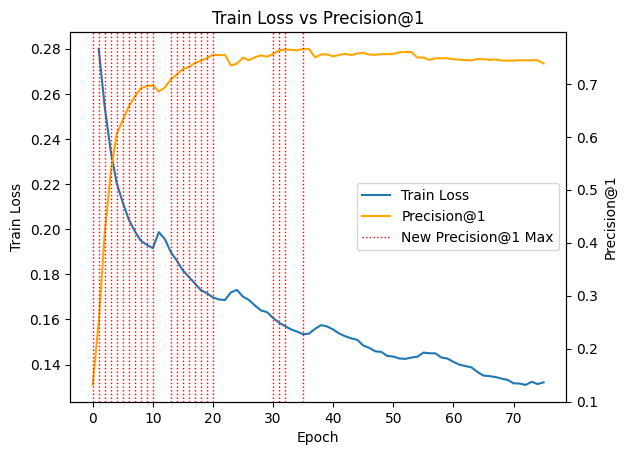

In [ ]:
fig, ax = plt.subplots()

# Left axis
line1, = ax.plot(history.index, history['train_loss'], label='Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Train Loss')
ax.tick_params(axis='y')

# Right axis
ax2 = ax.twinx()
line2, = ax2.plot(history.index, history['precision_at_1'], color='orange', label='Precision@1')
ax2.set_ylabel('Precision@1')
ax2.tick_params(axis='y')

# Vertical lines for new maxes
vlines = []
for epoch, val in zip(new_max_epochs, max_vals):
    vline = ax2.axvline(x=epoch, linestyle=':', linewidth=1.0, color='red')
    vlines.append(vline)

handles = [line1, line2, vlines[0]]
labels = ['Train Loss', 'Precision@1', 'New Precision@1 Max']
ax.legend(handles, labels, loc='center right')

plt.title('Train Loss vs Precision@1')
plt.show()

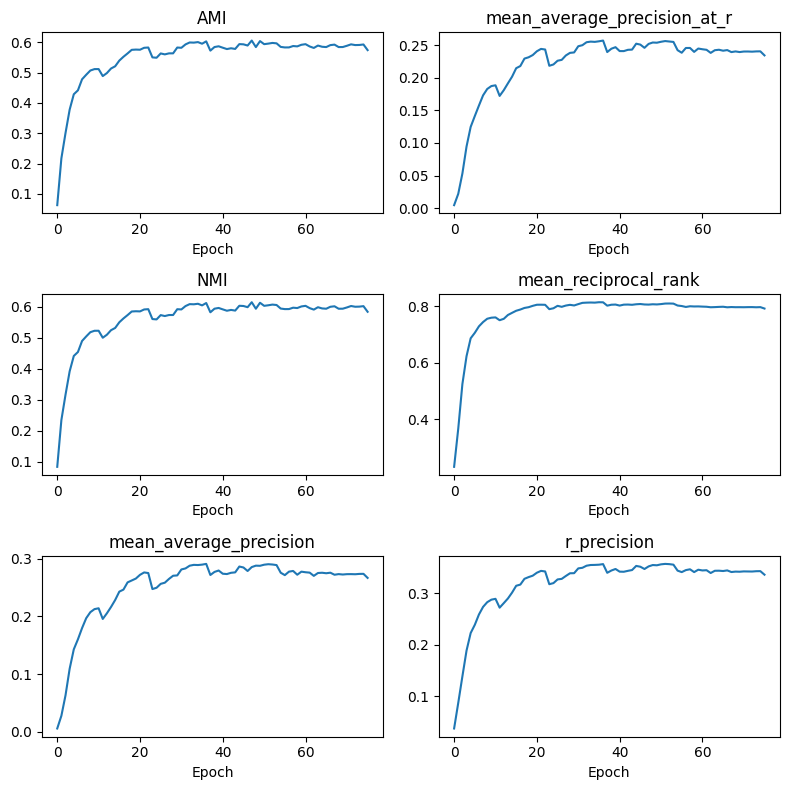

In [110]:
metrics = ['AMI', 'NMI', 'mean_average_precision', 'mean_average_precision_at_r', 'mean_reciprocal_rank', 'r_precision']
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
for i, metric in enumerate(metrics):
    ax = axes[i % 3][i // 3]
    
    ax.set_title(metric)
    ax.plot(history[metric])
    ax.set_xlabel('Epoch')
    
plt.tight_layout()

In [113]:
# Stats of best model
best_epoch = max_vals.index.max()
history.iloc[best_epoch, :]

AMI                            0.595810
NMI                            0.604514
mean_average_precision         0.289706
mean_average_precision_at_r    0.256087
mean_reciprocal_rank           0.815010
precision_at_1                 0.765890
r_precision                    0.354972
train_loss                     0.153423
Name: 35, dtype: float64

## 5. Export to ONNX for Java CV2 DNN

In [120]:
checkpoint = torch.load('model_checkpoints/best_model.pt', weights_only=False)
model = Model(3, 128)

model.load_state_dict(checkpoint['model_state_dict'])

torch.onnx.export(model, (torch.randn(1, 3, 128, 128),), "model_checkpoints/best_model.onnx")